# 자동차 번호판 영상으로 부터 숫자 검출
---

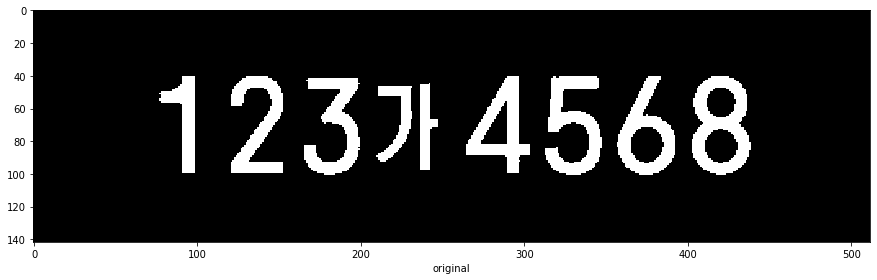

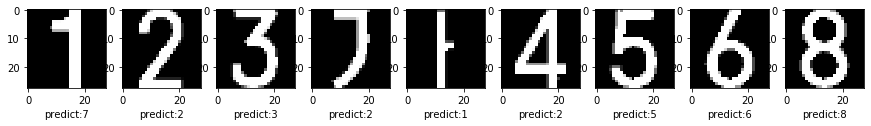

In [143]:
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

# --------------------------------

from models.mnist_dok_0521 import model, checkpoint, input_shape

# --------------------------------

def calc_padding(x, y, padding):
    x0, y0 = (x+padding,    y+padding)
    x1, y1 = (x+w-padding,  y+h-padding)
    return x0, y0, x1, y1

# --------------------------------
# 이미지 불러오기 & 이진화
# --------------------------------

frame = cv2.imread("res/img/자동차 번호판.jpeg")

frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
ret, frame_thresh = cv2.threshold(frame_gray, 128, 255, cv2.THRESH_BINARY_INV)

# --------------------------------
# 패딩을 이용하여 문자영역만 남기고 테두리 제거
# --------------------------------

# 1. 빈 프레임 생성
frame_letters = np.zeros(frame_thresh.shape, dtype=np.uint8)

# 2. 외곽선 검출
contours, hierachy = cv2.findContours(frame_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
extern_cont = contours[0]

# 3. 테두리를 제외한 영역 잘라내기
x,y,w,h = cv2.boundingRect(extern_cont)
x0,y0,x1,y1 = calc_padding(x,y,5)
frame_letters[y0:y1, x0:x1] = frame_thresh[y0:y1, x0:x1]

# --------------------------------
# 문자 영역으로부터 문자 검출 (모델에 입력할 데이터 생성)
# --------------------------------
contours, hierachy = cv2.findContours(frame_letters, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 랜덤 순으로 검출된 문자를 번호판에서의 문자 순서로 정렬
contours = sorted(contours, key=lambda cont: cv2.boundingRect(cont)[0]) # 바운딩 박스의 x,y,w,h중 x를 기준으로 sort

x_predict = []

for cont in contours:
    if cv2.contourArea(cont) < 20 : continue

    x,y,w,h = cv2.boundingRect(cont)

    # 1. 한 문자만을 마스킹하는 이미지 생성
    mask = np.zeros(frame_letters.shape, dtype=np.uint8)
    cv2.drawContours(mask, [cont], 0, 255, -1)

    # 2. 해당 문자만을 잘라냄
    masked = cv2.bitwise_and(frame_letters,frame_letters, mask=mask)[y:y+h, x:x+w]

    # 3. 새로 생성한 정사각형 형태의 프레임에 중앙에 문자 삽입
    n = max([h,w])
                         
    dx, dy = 0, 0 # 잘라낸 숫자를 (dx,dy)만큼 평행이동하여, 중앙에 위치하도록 옮김.
    if (w > h): dy = (w-h)//2
    else:       dx = (h-w)//2
                                
    square_frame = np.zeros((n,n), dtype=np.uint8)
    square_frame[dy:dy+h, dx:dx+w] = frame_char

    # 4. 모델에 입력할 수 있는 형태가 되도록 데이터의 크기를 조정
    _x = cv2.resize(square_frame, (28,28))
    _x.reshape(input_shape)

    x_predict.append(_x)

# --------------------------------
# 문자 영역으로부터 문자 검출
# --------------------------------
model.load_weights(checkpoint)

x_predict = np.array(x_predict)
y_predict = [np.where(p == max(p))[0][0] for p in model.predict(x_predict)]

# --------------------------------
# 결과 출력
# --------------------------------
n_of_contours = len(contours)

plt.figure(figsize=(15,10))
plt.xlabel('original')
plt.imshow(frame_letters, cmap='gray')

fig, axs = plt.subplots(1, n_of_contours, figsize=(15,9))
for i in range(n_of_contours):
    axs[i].imshow(np.squeeze(x_predict[i]), cmap='gray')
    axs[i].set_xlabel('predict:'+str(y_predict[i]))

fig.show()

# Tesseract를 이용한 문자 검출
---

## matplotlib에서 한글이 깨지는 문제 해결: 폰트 설정http://corazzon.github.io/matplotlib_font_setting

# 깃허브에서 참조..
---

* 테서렉트 설치 : https://tesseract-ocr.github.io/tessdoc/Home.html
    * https://github.com/tesseract-ocr/tesseract
    

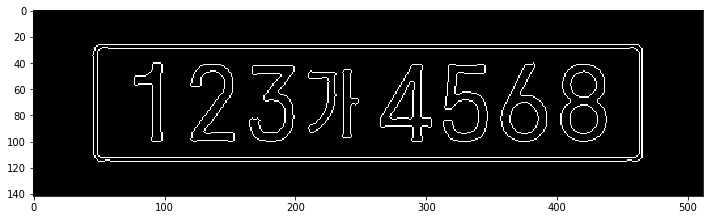

In [9]:
import numpy as np
import cv2.qt.plugins.platforms
from matplotlib import pyplot as plt

frame = cv2.imread("res/img/자동차 번호판.jpeg")
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame_blurred = cv2.GaussianBlur(frame_gray, ksize=(5, 5), sigmaX=0)
frame_thresh = cv2.adaptiveThreshold(
    frame_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9)

frame_morphed = cv2.morphologyEx(frame_thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

contours, hierarchy = cv2.findContours(
    frame_morphed, 
    mode=cv2.RETR_TREE, 
    method=cv2.CHAIN_APPROX_SIMPLE)

new_frame = np.zeros(frame_gray.shape, dtype=np.uint8)
cv2.drawContours(new_frame, contours, -1, 255,1)

plt.figure(figsize=(12,10))
plt.imshow(new_frame, cmap='gray')

# Tesseract 설치과정

```shell
brew install tesseract
brew install tesseract-lang
```

In [58]:
# http://corazzon.github.io/matplotlib_font_setting

import matplotlib as mpl
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list_mac = fm.OSXInstalledFonts()

search_keyword = 'Neo'
searched_fonts = [(f.name, f.fname) for f in fm.fontManager.ttflist if search_keyword in f.name]
print(searched_fonts)

[('Apple SD Gothic Neo', '/System/Library/Fonts/AppleSDGothicNeo.ttc')]


Text(0.5, 0, '')

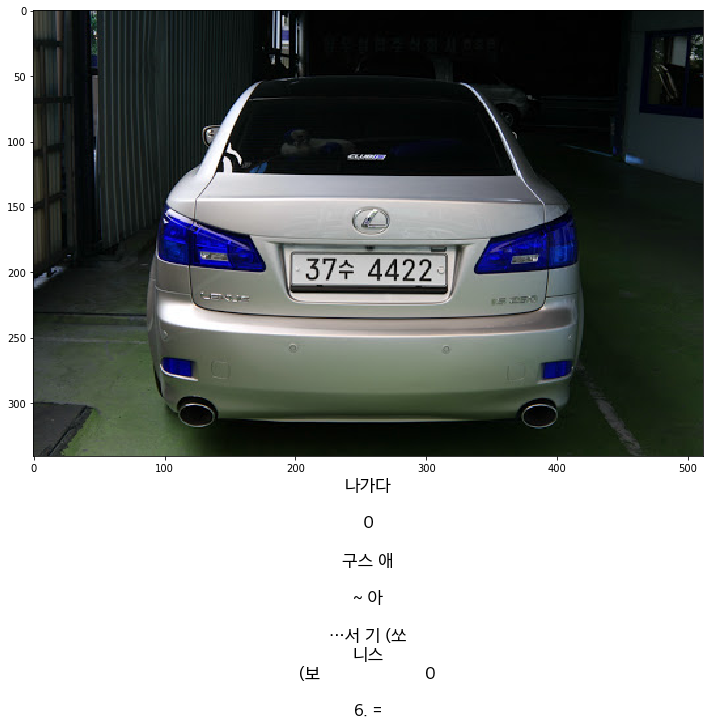

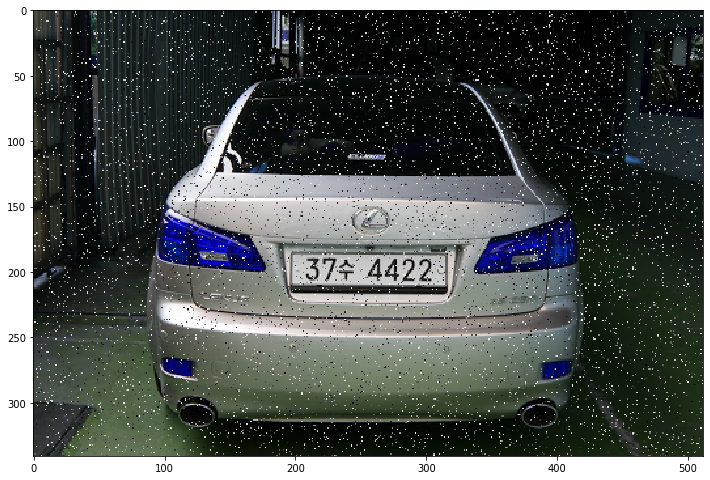

In [63]:
# -*- coding:utf-8 -*-
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pytesseract

# frame = cv2.imread("res/img/자동차 번호판.jpeg")
frame = cv2.imread("res/img/자동차.jpeg")

def noise(frame, noise_n):
    frame = frame.copy()

    h,w = frame.shape[:2]
    for _ in range(noise_n):
        x = np.random.random_integers(w-1)
        y = np.random.random_integers(h-1)
        
        r = np.random.random_integers(255)
        frame[y,x] = r
    return frame

def ocr(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_blurred = cv2.GaussianBlur(frame_gray, ksize=(5, 5), sigmaX=0)
    frame_thresh = cv2.adaptiveThreshold(
        frame_blurred, 
        maxValue=255.0, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY_INV, 
        blockSize=19, 
        C=9)
    frame_morphed = cv2.morphologyEx(frame_thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

    frame_input = cv2.cvtColor(frame_morphed, cv2.COLOR_GRAY2RGB)
    result = pytesseract.image_to_string(frame_input, lang='kor')
    return result

# 사용자에 맞게 적절히 수정
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', size=18)

plt.figure(figsize=(12,10))
plt.imshow(frame, cmap='gray')
plt.xlabel(ocr(frame), fontproperties=font)

frame_noised = noise(frame, 10000)

plt.figure(figsize=(12,10))
plt.imshow(frame_noised, cmap='gray')
plt.xlabel(ocr(frame_noised), fontproperties=font)